Each .csv file contains 18715 rows and t columns, where:

rows = cortical vertices (aligned across subjects)
columns = timepoints

Data has NOT been spatially smoothed along the cortical surface.

Filenames:
[n,e]_ses-1_task-[restingstate, openmonitoring, compassion].csv

where:
[n,e]                                      = subject groups [novices, experts]
[restingstate, openmonitoring, compassion] = states

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graspy

from pathlib import Path
import re
import os

import time
from tqdm import tqdm

import pickle
import h5py

In [46]:
basedir = Path('..')
datadir = basedir / 'data' / 'raw'
correlation_dir = basedir / 'data' / 'interim' / 'latents'

In [42]:
## Grab filenames
def get_files(level='(e|n)',
              subject='[0-9]{3}',
              task='.+?'):
    files = []
    query = f'^{level}_sub-'
    query += f'({subject})_ses-1_'
    query += f'task-{task}\.csv'
    for f in os.listdir(datadir):
        match = re.search(query, f)
        if match:
            files.append((f, match.group(1)))
    
    return(files)

In [43]:
e_paths = get_files(level=levels[0], task=tasks[0])

In [44]:
e_paths[0]

('e_sub-025_ses-1_task-restingstate.csv', '025')

In [47]:
tasks = ['restingstate', 'openmonitoring', 'compassion']
levels = ['e', 'n']

for task,level in np.array(np.meshgrid(tasks,levels)).T.reshape(-1,2):
    paths = get_files(level=level, task=task)
    
    for path,subj in paths:
        h5f = h5py.File(correlation_dir / f'{level}_sub-{subj}_ses-1_task-{task}_latent.h5', 'w')
        h5f.create_dataset('dataset_temp', data=e_compassion[:3])
        h5f.close()
        break
    break

In [19]:
e_compassion

(18715, 300)

In [6]:
n_max = 2
e_corrs = []
for path in e_paths[:n_max]:
    e_compassion = pd.read_csv(datadir / path, header = None).to_numpy()
    e_corrs.append(np.corrcoef(e_compassion))
    e_compassion = None
        #with open(external_correlation_dir / e_paths[0].replace('.csv', 'pkl'),'wb') as f:
        #    pickle.dump(e_corr, f)

In [11]:
e_compassion_A = [pd.read_csv(datadir / path, header = None).to_numpy() for path in e_paths]

In [42]:
ns = []
ts = []

In [47]:
n = 10000
n2 = [e1.shape[0]]

for i in n2:
    if not i in ns:
        ns.append(i)
        t1 = time.time()
        corr1 = np.corrcoef(e1[0:i,:])
        ts.append(time.time() - t1)

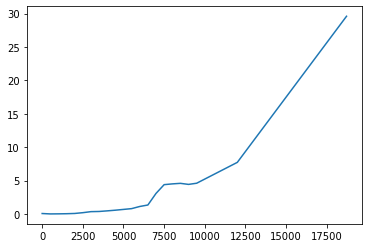

In [66]:
plt.plot(ns,ts)

## MASE
Data is symmetric
### Process
1. load n $p\times t$ matrices
2. compute $p \times p$ correlation matrices
3. MASE(corr mats) -> a $p \times d$ shared (left) latent position mat and n $d \times d$ transformation mats
4. multiply -> individual latent positions

latent_left_ : array, shape (n_samples, n_components)
        Estimated left latent positions of the graph. 
        
scores_ : array, shape (n_samples, n_components, n_components)
    Estimated :math:`\hat{R}` matrices for each input graph.


In [7]:
from graspy.embed import mase

In [8]:
mase = mase.MultipleASE()

In [9]:
mase.fit(e_corrs)

MultipleASE(algorithm='randomized', n_components=None, n_elbows=2, n_iter=5,
            scaled=False)

In [13]:
with open(basedir / 'data' / 'interim' / 'mase_e_compassion_first_two.pkl','wb') as f:
    pickle.dump(mase, f)
#with open('test.pkl','rb') as f:
#    x = pickle.load(f)

In [25]:
latents = mase.latent_left_
scores = mase.scores_

In [24]:
e1_transform, e2_transform = scores

In [38]:
e1_latent = latents @ e1_transform
e2_latent = latents @ e2_transform

(array([  18.,   60.,  285., 1004., 2852., 4800., 5526., 2904., 1100.,
         166.]),
 array([-0.00432054, -0.00245649, -0.00059243,  0.00127162,  0.00313567,
         0.00499972,  0.00686377,  0.00872782,  0.01059188,  0.01245593,
         0.01431998]),
 <a list of 10 Patch objects>)

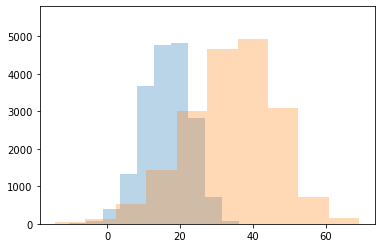

In [46]:
plt.hist(e1_latent[:,0], alpha=0.3)
plt.hist(e2_latent[:,0], alpha=0.3)
plt.hist(latents[:,0], alpha=0.3)
#plt.hist(e1_latent[:,2])